In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Queretaro'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban


### Census data

In [4]:
schema = 'sociodemografico'
folder = 'pobcenso_inegi_20_mzaageb_hex'

query = f"SELECT hex_id,pobtot FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
censo_gdf = aup.df_from_query(query)

print(censo_gdf.shape)
censo_gdf.head(2)

(2826, 2)


,hex_id,pobtot
0,894983d8997ffff,960.96387
1,894983c3697ffff,252.40027


### Nodes, edges, graphs

In [5]:
hex_gdf = hex_gdf.to_crs("EPSG:4326")

G,nodes,edges = aup.graph_from_hippo(hex_gdf, schema='osmnx', 
                    edges_folder='edges_speed_23_line', nodes_folder='nodes_osmnx_23_point')

### NDVI

In [9]:
schema = 'raster_analysis'
folder = 'ndvi_analysis_hex'

query = f"SELECT hex_id,ndvi_mean FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
ndvi_df = aup.df_from_query(query)

print(ndvi_df.shape)
ndvi_df.head(2)

(2826, 2)


,hex_id,ndvi_mean
0,894983d8997ffff,0.173743
1,894983d897bffff,0.320002


Hexágonos de resolución 11 filtrando aquellos con NDVI > 0.2. Calcular área. Extraer centroides. Intersección con hexágonos. Sumar área. Dividir entre población.

### Heat islands

In [18]:
schema = 'raster_analysis'
folder = 'temperature_analysis_hex'

query = f"SELECT hex_id,temperature_mean FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
temp_df = aup.df_from_query(query)
temp_df['temperature_mean'] = temp_df['temperature_mean'] - temp_df['temperature_mean'].mean()

print(temp_df.shape)
temp_df.head(2)

(2826, 2)


,hex_id,temperature_mean
0,894983d8997ffff,0.190589
1,894983c3697ffff,2.035772


### NDMI

In [23]:
schema = 'raster_analysis'
folder = 'ndmi_analysis_hex'

query = f"SELECT hex_id,ndmi_diff FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
ndmi_df = aup.df_from_query(query)

print(ndmi_df.shape)
ndmi_df.head(2)

(2826, 2)


,hex_id,ndmi_diff
0,894983d8997ffff,0.067874
1,894983c3697ffff,0.174133


### Green spaces point

In [6]:
green_point = gpd.read_file('../data/processed/espacios_publicos_point_amg.geojson')
print(green_point.shape)
green_point.head(2)

(309845, 15)


,Nombre_del,Estado_del,Nombre_de0,ID,Tipo_de_es,Superficie,layer,path,vertex_index,vertex_part,vertex_part_ring,vertex_part_index,distance,angle,geometry
0,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,0,0,0,0,0.000000,246.816795,POINT (654289.910 2262353.862)
1,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,1,0,0,1,3.101983,264.661886,POINT (654286.904 2262353.098)


### Green spaces area

In [7]:
green_area = gpd.read_file('../data/processed/espacios_publicos_amg.geojson')
print(green_area.shape)
green_area.head(2)

(4271, 9)


,Nombre_del,Estado_del,Nombre_de0,ID,Tipo_de_es,Superficie,layer,path,geometry
0,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"POLYGON ((654289.910 2262353.862, 654286.904 2..."
1,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"POLYGON ((654650.160 2262883.428, 654642.771 2..."


## Average NDVI

In [11]:
# hex_gdf = hex_gdf.to_crs("EPSG:32613")
# ndvi_hex = ndvi_gdf.overlay(hex_gdf, how='intersection')

In [12]:
'''# calculate length
ndvi_hex['length'] = ndvi_hex.length

# calculate total length by hexagon
ndvi_len = ndvi_hex[['hex_id_9','length']].groupby(['hex_id_9']).sum()
ndvi_len = ndvi_len.reset_index()
ndvi_len = ndvi_len.rename(columns={'length':'length_tot'})

# calculate percentage
ndvi_hex = ndvi_hex.merge(ndvi_len, on='hex_id_9')
ndvi_hex['pct_length'] = ndvi_hex['length'] / ndvi_hex['length_tot']

# calculate weight
ndvi_hex['wgt_ndvi'] = ndvi_hex['pct_length'] * ndvi_hex['__mean']

# calculate weighted mean
ndvi_hex = ndvi_hex[['hex_id_9','wgt_ndvi']].groupby(['hex_id_9']).sum()
ndvi_hex = ndvi_hex.reset_index()

print(ndvi_hex.shape)
ndvi_hex.head(2)'''

"# calculate length\nndvi_hex['length'] = ndvi_hex.length\n\n# calculate total length by hexagon\nndvi_len = ndvi_hex[['hex_id_9','length']].groupby(['hex_id_9']).sum()\nndvi_len = ndvi_len.reset_index()\nndvi_len = ndvi_len.rename(columns={'length':'length_tot'})\n\n# calculate percentage\nndvi_hex = ndvi_hex.merge(ndvi_len, on='hex_id_9')\nndvi_hex['pct_length'] = ndvi_hex['length'] / ndvi_hex['length_tot']\n\n# calculate weight\nndvi_hex['wgt_ndvi'] = ndvi_hex['pct_length'] * ndvi_hex['__mean']\n\n# calculate weighted mean\nndvi_hex = ndvi_hex[['hex_id_9','wgt_ndvi']].groupby(['hex_id_9']).sum()\nndvi_hex = ndvi_hex.reset_index()\n\nprint(ndvi_hex.shape)\nndvi_hex.head(2)"

In [7]:
hex_ndvi = hex_gdf.merge(ndvi_gdf[['hex_id','ndvi_mean']],
                         left_on='hex_id_9', right_on='hex_id', how='left')
print(hex_ndvi.shape)
hex_ndvi.head(2)

(2826, 8)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,hex_id,ndvi_mean
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban,894983d8997ffff,0.173743
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban,894983c3697ffff,0.179758


<Axes: >

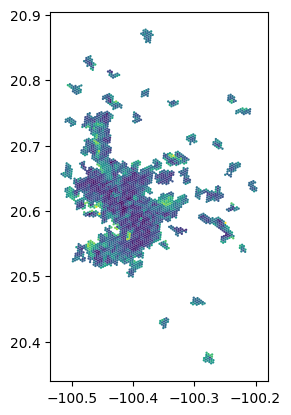

In [8]:
hex_ndvi.plot('ndvi_mean')

## m² per person

### NDVI res 11

In [8]:
ndvi_area = gpd.GeoDataFrame()

for v in range(3):
    ndvi_area = pd.concat([ndvi_area,
                           gpd.read_file(f'../../../data/processed/Distrito_QRO/Queretaro_ndvi_HexRes11_v{v}.geojson')])
    ndvi_area = ndvi_area.loc[ndvi_area.ndvi_mean>=0.25]
print(ndvi_area.shape)
ndvi_area.head(2)

(188137, 17)


,hex_id,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city,geometry
0,8b4983d8dad2fff,11,0.442706,0.136804,0.414820,0.614522,0.310956,0.303566,-0.002969,0.511517,0.481651,0.498962,0.517077,0.333033,0.313994,Queretaro,"POLYGON ((-100.45581 20.54971, -100.45564 20.5..."
2,8b4983c32819fff,11,0.366471,0.236895,0.276454,0.660594,0.227431,0.433162,-0.008019,0.660606,0.592895,0.304296,0.292394,0.216981,0.131652,Queretaro,"POLYGON ((-100.47281 20.55409, -100.47264 20.5..."


In [9]:
ndvi_area['area_m2'] = ndvi_area.to_crs("EPSG:32614").area

In [10]:
ndvi_area = ndvi_area.to_crs("EPSG:32614")
ndvi_area['geometry'] = ndvi_area.centroid

In [11]:
ndvi_area = ndvi_area[['area_m2','geometry']]
ndvi_area = ndvi_area.to_crs("EPSG:4326")
green_hex = ndvi_area.overlay(hex_gdf, how='intersection')

green_hex = green_hex.groupby('hex_id_9').sum(numeric_only=True)

hex_green = hex_gdf.merge(green_hex, on='hex_id_9', how='outer')
hex_green = hex_green.fillna(0)
print(hex_green.shape)
hex_green.head(2)

(2826, 7)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,area_m2
0,8949822402fffff,"POLYGON ((-100.2089 20.74718, -100.20765 20.74...",22011,El Marqués,Queretaro,urban,90189.209437
1,89498224103ffff,"POLYGON ((-100.22424 20.75045, -100.223 20.752...",22011,El Marqués,Queretaro,urban,115255.297288


In [12]:
hex_green = hex_green.merge(censo_gdf, left_on='hex_id_9',
                            right_on='hex_id', how='left')
hex_green.loc[hex_green.pobtot==0,'pobtot'] = 1
hex_green['area_pob'] = hex_green['area_m2'] / hex_green['pobtot']
hex_green = hex_green.fillna(0)
print(hex_green.shape)
hex_green.head(2)

(2826, 10)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,area_m2,hex_id,pobtot,area_pob
0,8949822402fffff,"POLYGON ((-100.2089 20.74718, -100.20765 20.74...",22011,El Marqués,Queretaro,urban,90189.209437,8949822402fffff,35.484356,2541.661160
1,89498224103ffff,"POLYGON ((-100.22424 20.75045, -100.223 20.752...",22011,El Marqués,Queretaro,urban,115255.297288,89498224103ffff,194.854420,591.494395


In [17]:
hex_green.loc[hex_green.area_pob>250,'area_pob'] = 250

<Axes: >

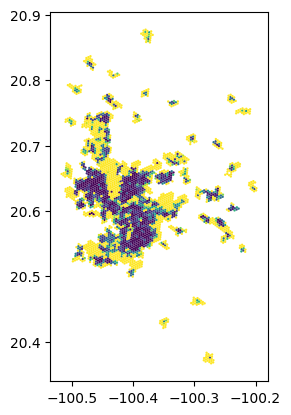

In [18]:
hex_green.plot('area_pob')

## Proximity to green spaces

In [49]:
green_point = green_point.to_crs("EPSG:4326")
green_osmid = proylib.find_nearest(G, nodes, green_point, return_distance= True)
nodes_green = proylib.calculate_distance_nearest_poi(green_osmid, nodes, 
                                       edges, 'ep', 'osmid', wght='time_min')
nodes_green = nodes_green.reset_index()
nodes_green.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_ep
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),2.523255
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),3.938320
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),0.000000
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),0.000000


In [51]:
nodes_green = nodes_green.to_crs("EPSG:32613")
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_prox = proylib.group_by_hex_mean(nodes_green, hex_gdf, 9, 'dist_ep')
print(hex_prox.shape)
hex_prox.head(2)

(1214, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_ep
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,2.888454
1,89498c97303ffff,"POLYGON ((680447.784 2285361.927, 680573.012 2...",14039,Guadalajara,Guadalajara,urban,102336.277778,-103.268420,20.660764,2.555556,1523.611111,5.575029


<AxesSubplot: >

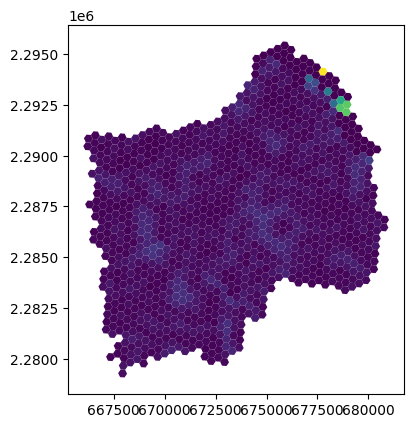

In [52]:
hex_prox.plot('dist_ep')

## Merge data

In [24]:
hex_env = hex_gdf.merge(ndvi_df[['hex_id','ndvi_mean']],
                        left_on='hex_id_9', right_on='hex_id',
                        how='left')
hex_env = hex_env.merge(ndmi_df[['hex_id','ndmi_diff']], 
                        left_on='hex_id_9', right_on='hex_id', how='left')
hex_env = hex_env.merge(temp_df[['hex_id','temperature_mean']], 
                        left_on='hex_id_9', right_on='hex_id', how='left')

In [26]:
hex_env = hex_env.drop(columns = ['hex_id_x','hex_id_y','hex_id'])

In [27]:
hex_env.head(2)

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ndvi_mean,ndmi_diff,temperature_mean
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban,0.173743,0.067874,0.190589
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban,0.179758,0.174133,2.035772


In [28]:
hex_env.to_file('../../../data/processed/Distrito_QRO/hex_environmental.geojson')